# Math

In [1]:
from utils.utils import *
from utils.plot_utils import *
from utils.data_utils import *
from utils.eval_refusal import *
from utils.attribution_utils import *
from tqdm import tqdm
from collections import defaultdict,Counter
import os
from utils.gemmascope import JumpReLUSAE_Base,get_optimal_file
from sae_lens import SAE
from transformer_lens import utils, HookedTransformer
import numpy as np
import torch.nn.functional as F
from einops import einsum
import pickle
from copy import deepcopy
import requests
import pandas as pd
import gc
with open('openai_key.txt','r') as f:
    openai_key = f.read().strip()
os.environ['OPENAI_API_KEY'] = openai_key

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_grad_enabled(False) # rmb set to true for grads

INFO 04-08 17:46:12 __init__.py:190] Automatically detected platform cuda.


In [ ]:
# Load model and SAE

device = 'cuda:0'
torch_dtype = torch.bfloat16
model_name = "google/gemma-2-2b"
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
    default_padding_side = 'left',
    default_prepend_bos = True,
    torch_dtype = torch_dtype,
    device = device
)  
model.tokenizer.add_bos_token=True

# Load sae
size = '65k' if 'gemma' in model_name else '32k'
sae_layers = model.cfg.n_layers
saes = {}
comps = ['res']

sae_naming = {
    'res': 'blocks.{l}.hook_resid_post',
    'mlp': 'blocks.{l}.hook_mlp_post',
    'attn': 'blocks.{l}.attn.hook_z',
}
for comp in comps:
    sae_key_fn = sae_naming[comp]
    for layer in range(sae_layers):
        if 'gemma' in model_name:
            repo_id = f"google/gemma-scope-2b-pt-res"
            sae_path = get_optimal_file(repo_id, layer,size)
            saes[sae_key_fn.format(l=layer)] = JumpReLUSAE_Base.from_pretrained(repo_id, sae_path, device).to(torch_dtype).to(device)
        else:
            sae,_,_=SAE.from_pretrained(release="llama_scope_lxr_8x", sae_id=f"l{layer}r_8x", device=device)
            saes[sae_key_fn.format(l=layer)] = sae.to(torch_dtype)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [3]:
from IPython.display import IFrame
saes_descriptions = defaultdict(defaultdict)
comps = ['res']

if 'gemma' in model_name.lower(): # llama cant export for some reason, only can take ad-hoc feature
    url = f"https://www.neuronpedia.org/api/explanation/export?modelId=gemma-2-2b&saeId={layer}-gemmascope-{comp}-{size}"
    neuropedia_path = f'{"gemma" if "gemma" in model_name.lower() else "llama"}_res_neuropedia.pkl'
    if not os.path.exists(neuropedia_path): # takes 5 min, just cache them for later use.
        for layer in tqdm(range(model.cfg.n_layers),total = model.cfg.n_layers):
            for comp in comps:
                
                headers = {"Content-Type": "application/json"}

                response = requests.get(url, headers=headers)
                data = response.json()
                explanations_df = pd.DataFrame(data)
                # # rename index to "feature"
                explanations_df.rename(columns={"index": "feature"}, inplace=True)
                explanations_df["feature"] = explanations_df["feature"].astype(int)
                explanations_df["description"] = explanations_df["description"].apply(
                    lambda x: x.lower()
                )
                saes_descriptions[layer][comp] = explanations_df
        with open(neuropedia_path,'wb') as f:
            pickle.dump(saes_descriptions,f)
    else:
        with open(neuropedia_path,'rb') as f:
            saes_descriptions = pickle.load(f)

def get_feat_description(feat,layer,comp = 'res'): # get the description given feature and layer
    if 'gemma' in model_name:
        df = saes_descriptions[layer][comp]
        try:
            return df[df["feature"] == feat]["description"].iloc[0]
        except:
            return "No description found"
    else:
        api_url = "https://www.neuronpedia.org/api/feature/llama3.1-8b/{l}-llamascope-res-{size}/{f}"
        try:
            data = requests.get(api_url.format(l=layer,f=feat,size= size)).json()
            return data["explanations"][0]["description"]
        except:
            return "No description found"

html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(model = "gemma-2-2b", layer=0, feature_idx=0):
    html_ = html_template.format(model, f'{layer}-{"gemmascope" if "gemma" in model else "llamascope"}-res-{size}', feature_idx)
    return html_

def get_max_act_approx(layer, feature_idx): # some fn to get the max act of a feature
    url = f"https://www.neuronpedia.org/api/feature/{'gemma-2-2b' if 'gemma' in model_name else 'llama3.1-8b'}/{layer}-{'gemmascope' if 'gemma' in model_name else 'llamascope'}-res-{size}/{feature_idx}"

    headers = {"X-Api-Key": "YOUR_SECRET_TOKEN"}

    response = requests.get(url, headers=headers)

    return response.json()['maxActApprox']

In [14]:
from collections import namedtuple
from typing import Any, Callable, Literal, TypeAlias
AnsConfig = namedtuple("AnsConfig", ["a", "b", "operation", "ans","a_ans"])

def prompt_generator(
    n_range: int = 100,
    op: list[str] = ["plus"],
    n_batch: int = 100,
    return_type: Literal["string", "token"] = "string",
    write_to_file: bool = False,
    file_path: str = "addition_prompts.txt",
    with_instructions: bool = False,
) -> tuple[list[str], list[AnsConfig]]:
    """
    Generates a list of arithmetic questions and their answers.
    """
    a = torch.randint(0, n_range, (n_batch,))
    aa = a + 10
    b = torch.randint(0, n_range, (n_batch,))
    
    a_instr = torch.randint(0, n_range, (n_batch,))
    b_instr = torch.randint(0, n_range, (n_batch,))
    
    ans_list = []
    q_list = []
    
    
    with open(file_path, "w") as f:
        for i in range(n_batch):
            
            operation = random.choice(op)

            # log the correct answer
            if operation == "plus":
                answer = a[i] + b[i]
                inst_answer = a_instr[i] + b_instr[i]
                alt_answer = aa[i] + b[i]
            elif operation == "minus":
                answer = a[i] - b[i]
                inst_answer = a_instr[i] - b_instr[i]
                alt_answer = aa[i] - b[i]
            elif operation == "times":
                answer = a[i] * b[i]
                inst_answer = a_instr[i] * b_instr[i]
                alt_answer = aa[i] * b[i]
            # elif operation == "divided by":
            #     answer = a[i] / b[i]
            
            if with_instructions:
                q_list.append(
                    f"{a_instr[i].item()} {operation} {b_instr[i].item()} is {inst_answer.item()}, {a[i].item()} {operation} {b[i].item()} is"
                )
            else:
                q_list.append(
                    (f"{a[i].item()} {operation} {b[i].item()} is",f"{aa[i].item()} {operation} {b[i].item()} is")
                )

            if write_to_file:
                f.write(q_list[-1] + "\n")
            
            ans_list.append(
                AnsConfig(
                    a=a[i].item(),
                    b=b[i].item(),
                    operation=operation,
                    ans=answer.item(),
                    a_ans=alt_answer.item()
                )
            )
    
    return q_list, ans_list

### Testing functionality
q_list, a_list = prompt_generator(with_instructions=False, n_batch=10)

In [ ]:
clean_prompts = [x[0] for x in q_list]
corrupt_prompts = [x[1] for x in q_list]

clean_ans = [str(x.ans) for x in a_list]
corrupt_ans = [str(x.a_ans) for x in a_list]

clean_ans_logit = [model.tokenizer.encode(x,add_special_tokens=False)[0] for x in clean_ans]
corrupt_ans_logit = [model.tokenizer.encode(x,add_special_tokens=False)[0] for x in corrupt_ans]


9
1
['97', '100', '102', '164', '58', '66', '66', '46', '106', '102']
['107', '110', '112', '174', '68', '76', '76', '56', '116', '112']


In [66]:
print (clean_ans)
print (corrupt_ans)

['97', '100', '102', '164', '58', '66', '66', '46', '106', '102']
['107', '110', '112', '174', '68', '76', '76', '56', '116', '112']


In [45]:
def linear_attribution(model,saes,ds,interpolate_steps = 1):
    """
    Use linear attribution to get the features for each token
    """

    clean_prompts = [x['clean_prompt'] for x in ds]
    corrupt_prompts = [x['corrupt_prompt'] for x in ds]
    clean_id = [x['clean_ans'] for x in ds]
    corrupt_id = [x['corrupt_ans'] for x in ds]

    def metric_fn(x):
        clean_logit = x[torch.arange(x.shape[0]),-1,clean_id]
        corrupt_logit = x[torch.arange(x.shape[0]),-1,corrupt_id]
        return corrupt_logit - clean_logit
    
    clean_input_ids = model.tokenizer(clean_prompts,return_tensors='pt',padding='longest').to(model.cfg.device)
    corrupt_input_ids = model.tokenizer(corrupt_prompts,return_tensors='pt',padding='longest').to(model.cfg.device)
    
    patch_cache = defaultdict(dict)
    clean_cache = {}
    with torch.no_grad():
        # Get patch = steered states
        model.reset_hooks()
        model.add_hook(resid_name_filter,partial(store_sae_feat,saes = saes,cache = patch_cache,store_error=True))
        _ = model(corrupt_input_ids.input_ids,attention_mask = corrupt_input_ids.attention_mask)
        model.reset_hooks()

        # get clean
        model.add_hook(resid_name_filter,partial(store_sae_feat,saes = saes,cache = clean_cache))
        _ = model(clean_input_ids.input_ids,attention_mask = clean_input_ids.attention_mask)
        model.reset_hooks()
    
    torch.set_grad_enabled(True) # allow grads
    # get grads (interpolate average across steps)
    all_grads = defaultdict(list)
    for step in range(interpolate_steps):
        model.reset_hooks()
        alpha = step/interpolate_steps
        grad_cache = {}
        model.add_hook(resid_name_filter,partial(sae_grad_patch_IG,grad_cache = grad_cache,saes=saes,patch_cache = patch_cache,alpha=alpha))
        model.add_hook(resid_name_filter,sae_bwd_hook,'bwd')
        logits = model(clean_input_ids.input_ids,attention_mask = clean_input_ids.attention_mask)
        loss = metric_fn(logits).mean()
        logits.grad = None
        for v in grad_cache.values():
            v.grad = None
        loss.backward()
        with torch.no_grad():
            for l,acts in grad_cache.items():
                all_grads[l].append(acts.grad.detach())
        del grad_cache
        torch.cuda.empty_cache()
    all_grads = {k:torch.stack(v).mean(0) for k,v in all_grads.items()}
    attrs = {}

    for l,clean_acts in clean_cache.items():
        delt = patch_cache['feat'][l] - clean_acts
        attrs[l] = (delt * all_grads[l]).detach().cpu()
    
    model.reset_hooks()
    del patch_cache
    del clean_cache
    del all_grads
    torch.set_grad_enabled(False)
    clear_mem()
    return attrs

In [70]:
# Check acc
clean_prompts_inps = model.tokenizer([x +' ' for x in clean_prompts],return_tensors='pt',padding='longest').to(model.cfg.device)
clean_logit = model(clean_prompts_inps.input_ids,attention_mask = clean_prompts_inps.attention_mask)[:,-1].argmax(-1).detach().cpu().tolist()

print (np.mean([x == y for x,y in zip(clean_logit,clean_ans_logit)]))

1.0


In [46]:
ds = [{'clean_prompt': clean_prompts[i],'corrupt_prompt': corrupt_prompts[i],'clean_ans': clean_ans_logit[i],'corrupt_ans': corrupt_ans_logit[i]} for i in range(len(clean_prompts))]

circuit = linear_attribution(model,saes,ds,interpolate_steps = 10)

In [67]:
threshold = 0.01
threshold_cir,n_feats = create_circuit_mask(circuit,threshold,clamp_val = 0,device = model.cfg.device)
print (f"Number of features above threshold: {n_feats}")


Number of features above threshold: 15.6


Prompt: 27 plus 70 is


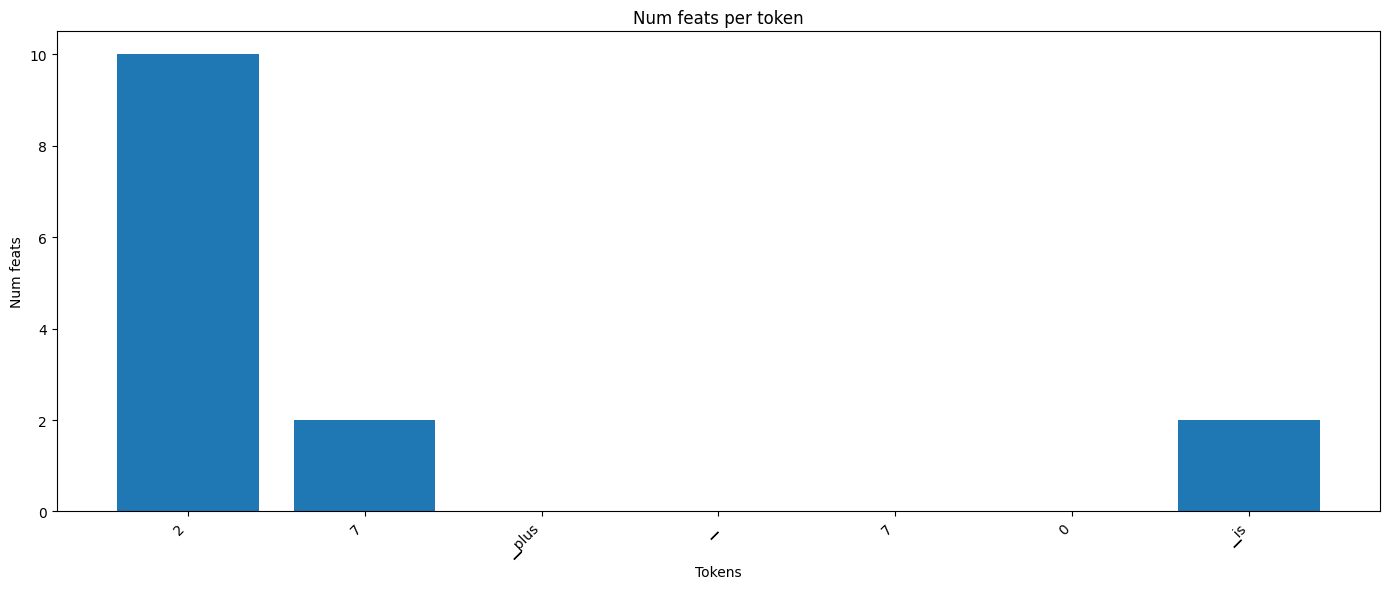

Layer 1, Feature 31864, tokens: ['2'],description: numerical values
Layer 2, Feature 297, tokens: ['2'],description:  numerical values, particularly in forms of measurements or identifiers
Layer 3, Feature 33275, tokens: ['2'],description:  numerical values, particularly those that are significant or used in various contexts
Layer 5, Feature 39350, tokens: ['2'],description: references to dates or numerical data
Layer 6, Feature 17003, tokens: ['2'],description:  occurrences of numeric representations and mathematical functions
Layer 7, Feature 56376, tokens: ['2'],description:  numeric values
Layer 9, Feature 40150, tokens: ['2'],description:  numerical identifiers or designations in mathematical contexts
Layer 10, Feature 26348, tokens: ['2'],description:  patterns and relationships in mathematical expressions
Layer 11, Feature 22636, tokens: ['2'],description: numbers and mathematical concepts, particularly involving prime factors
Layer 13, Feature 48615, tokens: ['2'],description: 

In [69]:
encoded_input = model.tokenizer(clean_prompts,return_tensors='pt',padding='longest').input_ids

sae_circuit_list,encoded_input = circuit_tolist(threshold_cir,encoded_input,remove_padding=True,ignore_bos = True)
sample_id = 0
sample_circuit = sae_circuit_list[sample_id]
sample_tokens = model.tokenizer.convert_ids_to_tokens(encoded_input[sample_id])

all_feats = []
token_feats_counts = []
feat_to_tokens = defaultdict(list)
for j,xx in enumerate(sample_circuit):
    all_feats.extend(xx)
    token_feats_counts.append(len(xx))
    for x in xx:
        feat_to_tokens[x].append(sample_tokens[j])

print (f'Prompt: {clean_prompts[sample_id]}')
plot_bar(token_feats_counts, x_tick=[str(x) if x != '\n' else '<newline>' for x in sample_tokens], ylabel='Num feats', xlabel='Tokens', title='Num feats per token')

for l,f in all_feats:
    print (f'Layer {l}, Feature {f}, tokens: {feat_to_tokens[(l,f)]},description: {get_feat_description(f,l)}')